# Topas Work - Team protons and heavy ions
### PHY-7051 Physique des radiations en radiothérapie et en radiologie
Gabrielle Germain (111 266 117), Hanieh Sadat Jozi (111 XXX XXX), Philippe Dionne (111 XXX XXX)

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Useful functions

In [131]:
def csv_to_data(path:str, skiprows:int=9, delimiter:str=', ') -> tuple:
    """ Reads the csv file and converts it to a tuple containing 3 columns matrices

    Args:
        path (str): absolute path on the computer. Must have the format r"C:\path.csv"
        skiprows (int, optional): Rows to skip the header. Defaults to 9.
        delimiter (str, optional): Defaults to ', '.

    Returns:
        tuple: (bin, dose, standard-deviation)
    """

    data = np.loadtxt(path, skiprows=skiprows, delimiter=delimiter, usecols=(2, 3, 4))
    bin = data[:, 0]
    dose = data[:, 1]
    std = data[:, 2]
    return (bin, dose, std)

def droite(x, a, b):
    return a*x + b

Constants

In [132]:
MeV_to_joule = 1.602176565e-13 # J/MeV

## Central-axis depth-dose distribution in water of a monoenergetic beam of protons or carbon ions

### Reproduction de la figure 6.12 du manuel [1]

__Attention__: La mise en forme du code est grandement inspirée du notebook jupyter de l'équipe électrons de l'automne 2022. Le code est toutefois original, même s'il est similaire à certains endroits.

Au total, trois combinaisons de _physics list_ ont été testées afin de reproduire la figure 6.12 du manuel. Ces combinaisons sont les suivantes:
* "g4em-standard_opt4" 
* "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"
* "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" 
* "g4em-standard_opt4" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"


Aussi, les _path_ sont absolus, les paths relatifs ne fonctionnaient pas...

In [133]:
# ------------------------------- Paramètres  identiques pour tous les essais------------------------------------------- #

field_size = 100 # cm2
energies_p = np.array([122, 183, 230])      # MeV
energies_c = np.array([220, 350, 430])      # MeV/u, u = 12
nbr_p = 100000 # nbr de protons simulés pour chaque énergie
nbr_c = 10000 # nbr d'ions de carbone simulés pour chaque énergie
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
np.seterr(divide='ignore', invalid='ignore')
marker = ['-','--','-.',':','k-','k--','k-.','k:']


Protons de  122 MeV - Erreur relative suffisante atteinte!
0.0237 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0165 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00408 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.241 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.147 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0738 % < 3 %


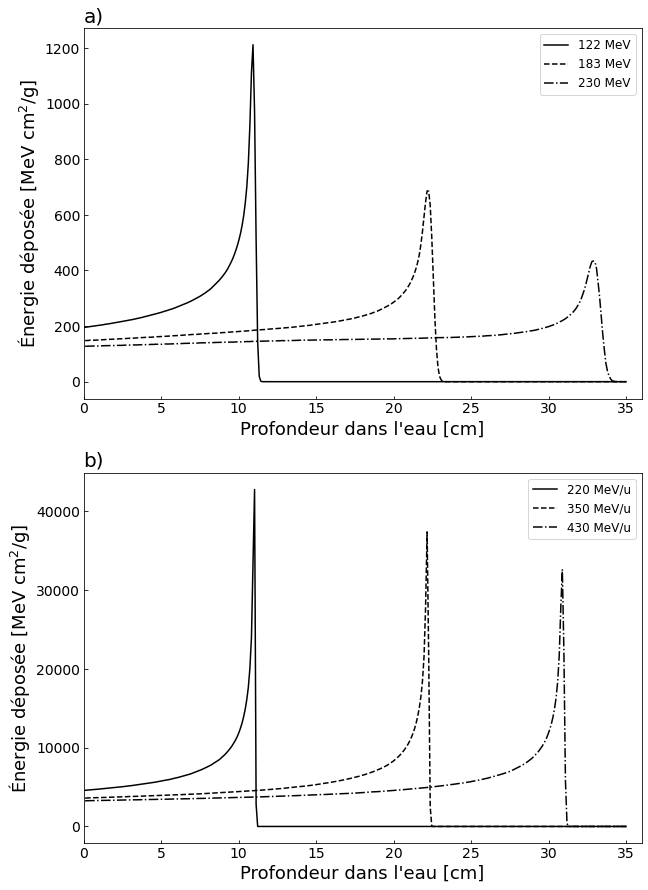

In [134]:
""" 
Essai 1 avec module suivant: "g4em-standard_opt4"
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v1.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v1.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')



Protons de  122 MeV - Erreur relative suffisante atteinte!
0.157 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0924 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00884 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.143 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.0452 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0263 % < 3 %


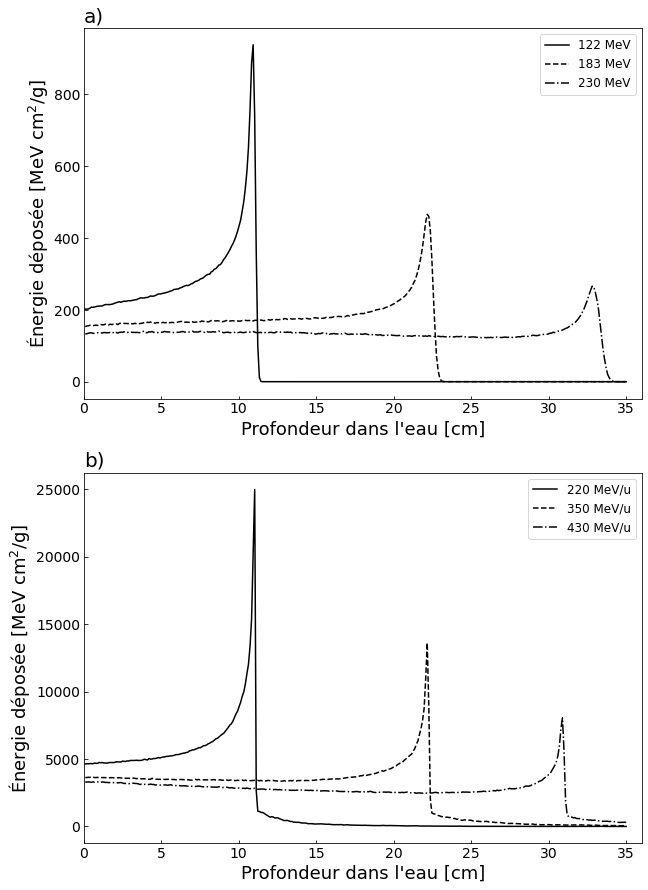

In [135]:
"""
Essai 2 avec 6 modules: "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"
On peut maintenant voir les effets des interactions nucléaires, toutefois, l'échelle de la dose n'est toujours pas la bonne
Cet essai a été utilisé pour évaluer les relations entre l'énergie, la position des pics de Bragg et Rp
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
braggpeak_p = np.empty(np.size(energies_p))
Rp_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
braggpeak_c = np.empty(np.size(energies_c))
Rp_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v2.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Pic de Bragg et Rp
    braggpeak_p[i] = depth[np.argmax(dose)]
    norm_dose = dose/np.max(dose)
    j = 0
    while norm_dose[j] > 0.1:
        j+=1
    Rp_p[i] = depth[j]

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v2.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Pic de Bragg et Rp
    braggpeak_c[i] = depth[np.argmax(dose)]
    norm_dose = dose/np.max(dose)
    j = 0
    while norm_dose[j] > 0.1:
        j+=1
    Rp_c[i] = depth[j]

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')



Protons de  122 MeV - Erreur relative suffisante atteinte!
0.103 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0669 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00791 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.241 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.147 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0738 % < 3 %


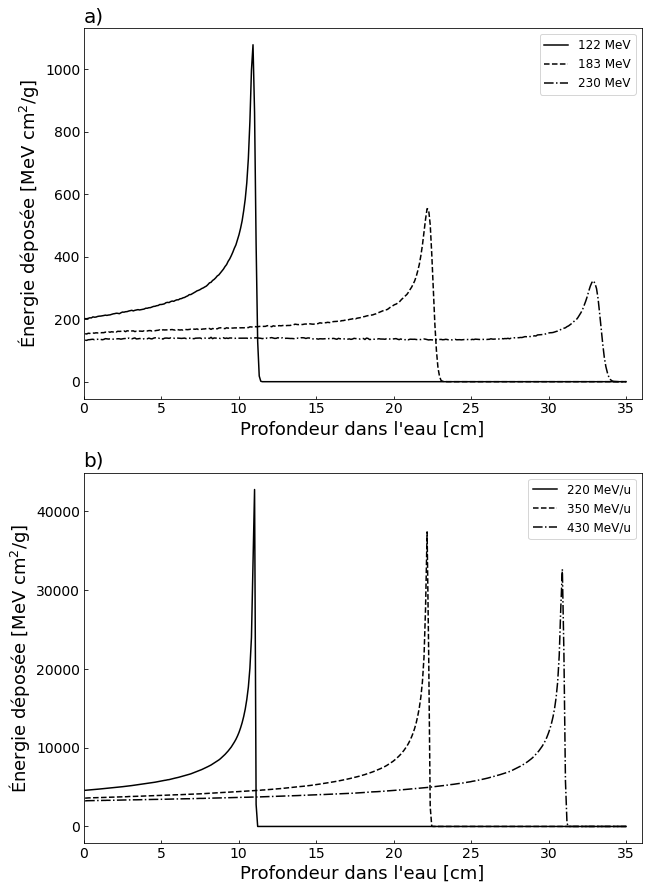

In [136]:
"""
Essai 3 avec 2 modules(script carbone_testmodules1.txt): "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP"
On perd la queue dans la figure du carbone.
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

nbr_p = np.array([100000, 100000, 100000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 10000]) # nbr d'ions de carbone simulés pour chaque énergie
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v3.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v3.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')


Protons de  122 MeV - Erreur relative suffisante atteinte!
0.0367 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0192 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00491 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.151 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.0448 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0263 % < 3 %


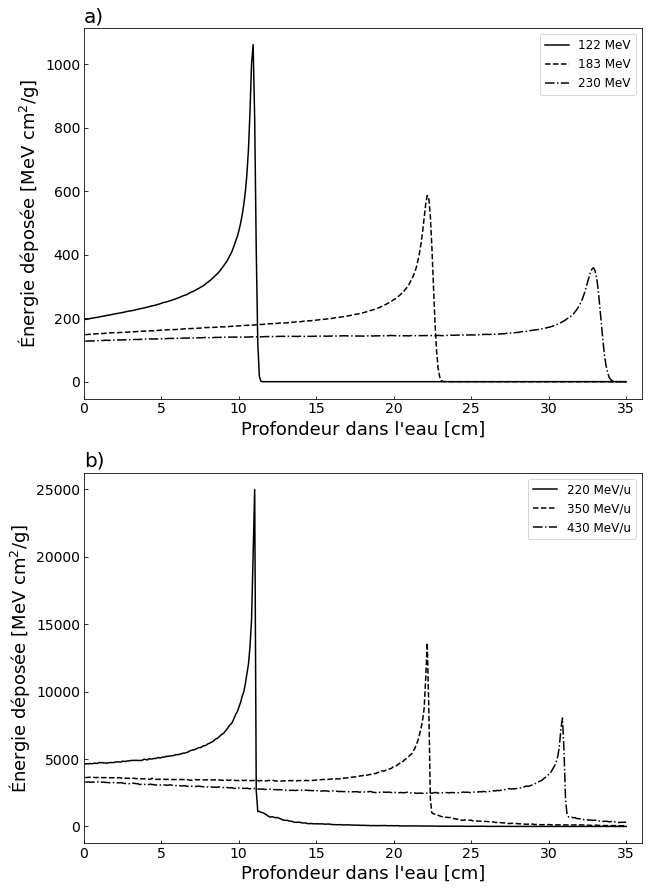

In [137]:
"""
Essai 4 avec modules:(script carbone_testmodules2.txt): sv:Ph/Default/Modules = 5 "g4em-standard_opt4" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"
Observations
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

nbr_p = np.array([100000, 100000, 100000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 10000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v4.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v4.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')

### Discussion sur les différentes figures générées



### Extraction de la position des pics de Bragg et des Rp

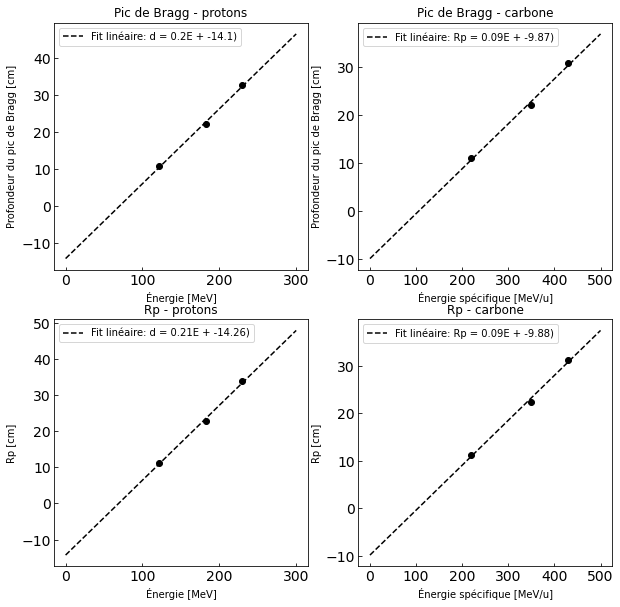

In [138]:
# Régressions linéaires
lin_energy_p = np.linspace(0, 300, 300)
lin_energy_c = np.linspace(0, 500, 500)

popt00, pcov00 = curve_fit(droite, energies_p, braggpeak_p)
popt10, pcov10 = curve_fit(droite, energies_p, Rp_p)
popt01, pcov01 = curve_fit(droite, energies_c, braggpeak_c)
popt11, pcov11 = curve_fit(droite, energies_c, Rp_c)

### Figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# pic bragg proton
axs[0,0].plot(energies_p, braggpeak_p, 'ko')
axs[0,0].plot(lin_energy_p, droite(lin_energy_p, *popt00), 'k--', label="Fit linéaire: d = {}E + {})".format(round(popt00[0],2),round(popt00[1],2)))
axs[0,0].set(xlabel="Énergie [MeV]", ylabel="Profondeur du pic de Bragg [cm]")
axs[0,0].set_title("Pic de Bragg - protons")
axs[0,0].tick_params(direction='in',labelsize='14')
axs[0,0].legend()
# Rp proton
axs[1,0].plot(energies_p, Rp_p, 'ko')
axs[1,0].plot(lin_energy_p, droite(lin_energy_p, *popt10), 'k--', label="Fit linéaire: d = {}E + {})".format(round(popt10[0],2),round(popt10[1],2)))
axs[1,0].set(xlabel="Énergie [MeV]", ylabel="Rp [cm]")
axs[1,0].set_title("Rp - protons")
axs[1,0].tick_params(direction='in',labelsize='14')
axs[1,0].legend()
# pic bragg carbone
axs[0,1].plot(energies_c, braggpeak_c, 'ko')
axs[0,1].set(xlabel="Énergie spécifique [MeV/u]", ylabel="Profondeur du pic de Bragg [cm]")
axs[0,1].plot(lin_energy_c, droite(lin_energy_c, *popt01), 'k--', label="Fit linéaire: Rp = {}E + {})".format(round(popt01[0],2),round(popt01[1],2)))
axs[0,1].set_title("Pic de Bragg - carbone")
axs[0,1].tick_params(direction='in',labelsize='14')
axs[0,1].legend()
# Rp carbone
axs[1,1].plot(energies_c, Rp_c, 'ko')
axs[1,1].set(xlabel="Énergie spécifique [MeV/u]", ylabel="Rp [cm]")
axs[1,1].plot(lin_energy_c, droite(lin_energy_c, *popt11), 'k--', label="Fit linéaire: Rp = {}E + {})".format(round(popt11[0],2),round(popt11[1],2)))
axs[1,1].set_title("Rp - carbone")
axs[1,1].tick_params(direction='in',labelsize='14')
axs[1,1].legend()

## Depth of the Bragg Peak for a carbon ions beam

## Beam quality of a pristine and modulated beam of proton

## Références

[1] P. Andreo, D. T. Burns, A. E. Nahum, J. Seuntjens, and F. H. Attix, Fundamentals of Ionizing Radiation Dosimetry, 1er édition. Wiley-VCH, 2017.

[2] P. Andreo, “On the clinical spatial resolution achievable with protons and heavier charged particle radiotherapy beams,” Phys. Med. Biol., vol. 54, no. 11, p. N205, May 2009, doi: 10.1088/0031-9155/54/11/N01.

[3] M. Testa et al., “Experimental validation of the TOPAS Monte Carlo system for passive scattering proton therapy,” Med Phys, vol. 40, no. 12, p. 121719, Dec. 2013, doi: 10.1118/1.4828781.